In [181]:
import PreLoader
import ArrayGenerator
import numpy as np
import matplotlib.pyplot as plt

In [2]:
preloader = PreLoader.PreLoader("vhr")

In [4]:
# Loading the data , we will with faults instead of status
ts = preloader.get_3d_ts_array()
labels = preloader.get_labels_array("faults")

In [5]:
x, y = ArrayGenerator.generate_dataset_array(
    dataset_category=3, ts=ts, labels=labels, split_method="bearing"
)

{'Faults classified': 'Flow problem', 'Channels taken': 'Machine channels only', 'Labels array': 'Binary'}


In [145]:
def ts_without_NaN(ts):
    new_ts = []
    for value in ts:
        if not np.isnan(value):
            new_ts.append(value)
    return new_ts

In [287]:
# Purging NaN values from our data
x_nonan = []
for bearing in x:
    x_nonan.append(bearing[:, ~np.any(np.isnan(bearing), axis=0)])

* Making sure that we didn't change with the data

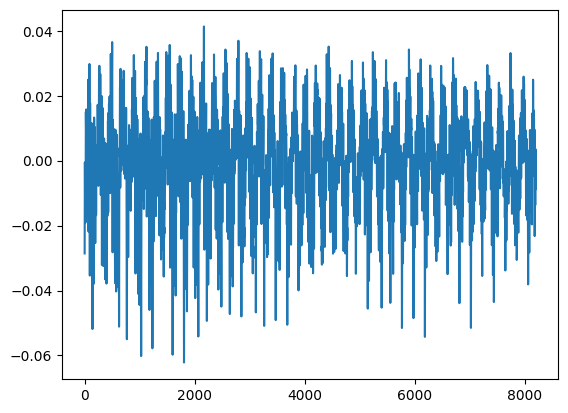

In [293]:
plt.plot(x_nonan[0][0])

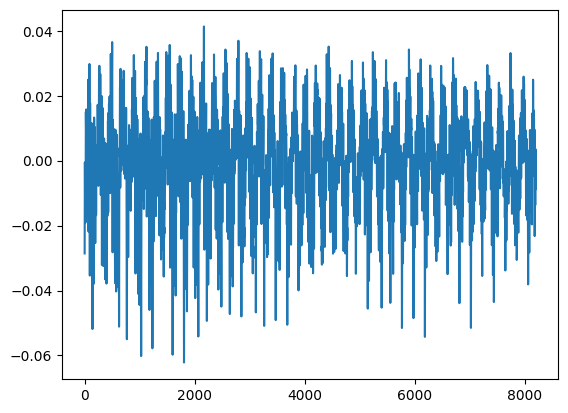

In [294]:
plt.plot(x[0][0])

In [295]:
#  Difference in length after removing NaNs
print(len(x[0][0]), len(x_nonan[0][0]))

16384 8192


* Getting FFT

In [291]:
x_FFT = []
for bearing in x_nonan:
    fft = []
    for channel in bearing:
        fft.append(np.array(ArrayGenerator.calculate_fft(channel)))
    x_FFT.append(np.array(fft))

* Making sure it's right

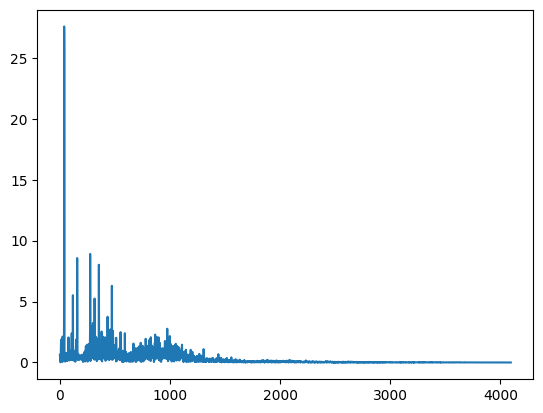

In [296]:
plt.plot(x_FFT[0][0])

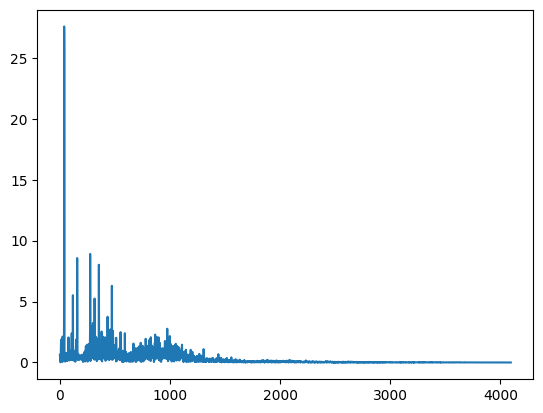

In [335]:
plt.plot(ArrayGenerator.calculate_fft(x_nonan[0][0]))
plt.show()

# Combining timeseries and its FFT into one big array.

It's shaped ike this x_ts_fft[ i ][ j ][0:the signal length without NaNs] contains the acual timesries unwindowed, and x_ts_fft[ i ][ j ][the signal length without NaNs:] would contain the timeseries' FFT

In [322]:
x_ts_fft = []
for i in range(len(x_nonan)):
    x_ts_fft.append(np.concatenate((x_nonan[i], x_FFT[i]), axis=1))

In [333]:
len(x_ts_fft)

# It has  the same length because we are adding the FFT in each channel's array

434

* An example of how the data is structured (note that the signals original length is indeed 8192)

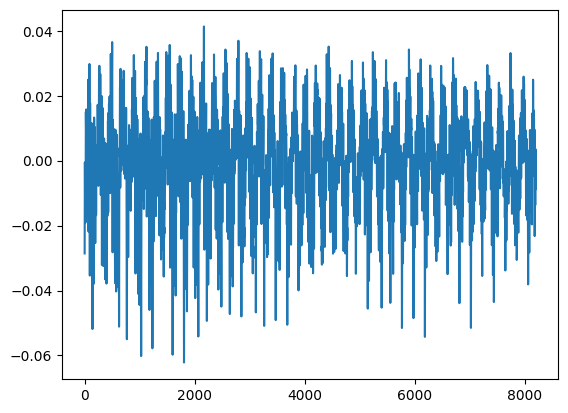

In [331]:
#  The timeseries
plt.plot(x_ts_fft[0][0][:8192])

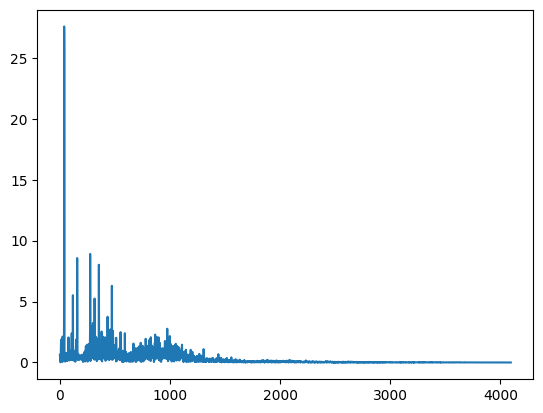

In [392]:
#  Its FFT right after it in the same array
plt.plot(x_ts_fft[0][0][8192:])

* Modifying the original apply_sliding_window so we can add the full timeseries' FFT after each of its windows

In [379]:
def apply_sliding_window_concatenate_fft(
    ts_3d, x_fft, labels, window_size=2084, overlap_pct=0.2
):
    x_new = []
    y_new = []
    j = 0
    for ts, label in zip(ts_3d, labels):
        ts = ts[:, ~np.any(np.isnan(ts), axis=0)]
        num_channels, signal_length = ts.shape
        overlap = int(window_size * overlap_pct)
        stride = window_size - overlap
        num_windows = (signal_length - window_size) // stride + 1

        x_temp = []

        y_temp = []

        for i in range(num_windows):
            start = i * stride
            end = start + window_size
            x_new.append(np.concatenate((ts[:, start:end], x_fft[j]), axis=1))
            y_new.append(label)

        # x_new.append(x_temp)
        # y_new.append(y_temp)
        j += 1
    # x_new, y_new = np.concatenate(x_new), np.concatenate(y_new)

    return x_new, y_new

In [380]:
x_windowed, y_windowed = apply_sliding_window_concatenate_fft(
    ts_3d=x, x_fft=x_FFT, labels=y, window_size=2048, overlap_pct=0.2
)

* A window of a timeseries and the full timeseries' FFT right after it

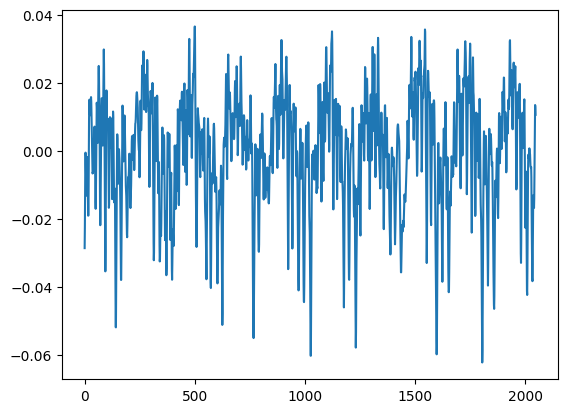

In [ ]:
plt.plot(x_windowed[0][0][:2048])

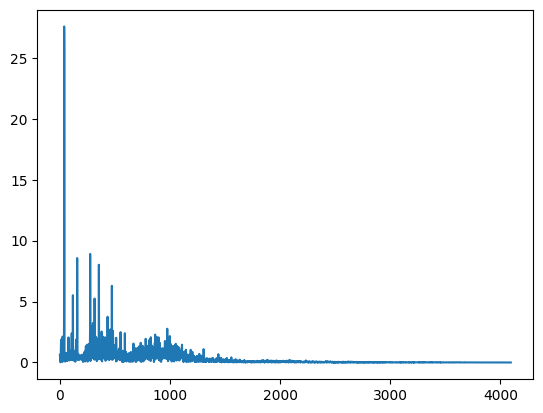

In [391]:
plt.plot(x_windowed[0][0][2048:])